# Time Series Anomoly Detection

In [1]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import env

## Acquired and saved to CSV

In [7]:
#create SQL connection to logs
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
#SQL query
query = 'select * from logs'
df = pd.read_sql(query, url)

In [8]:
df.to_csv('logs.csv', index=False)

In [9]:
# load df from csv
df = pd.read_csv('logs.csv')

In [10]:
df.head()

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900223 entries, 0 to 900222
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       900223 non-null  object 
 1   time       900223 non-null  object 
 2   path       900222 non-null  object 
 3   user_id    900223 non-null  int64  
 4   cohort_id  847330 non-null  float64
 5   ip         900223 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 41.2+ MB


## Prep

In [15]:
# setting index as datetime and creating a count series
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)
pages = df['path'].resample('d').count()
pages.head()


date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: path, dtype: int64

<Axes: xlabel='date'>

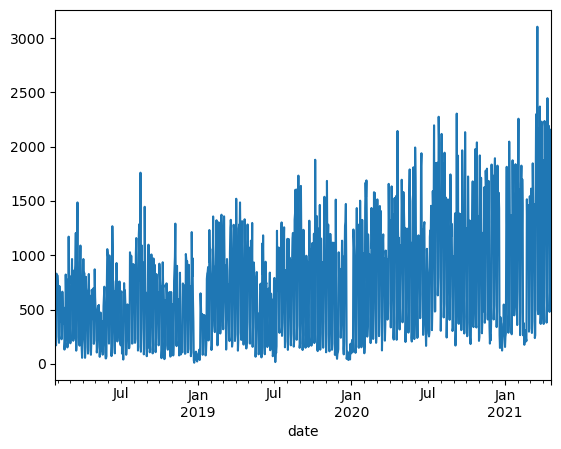

In [16]:
pages.plot()

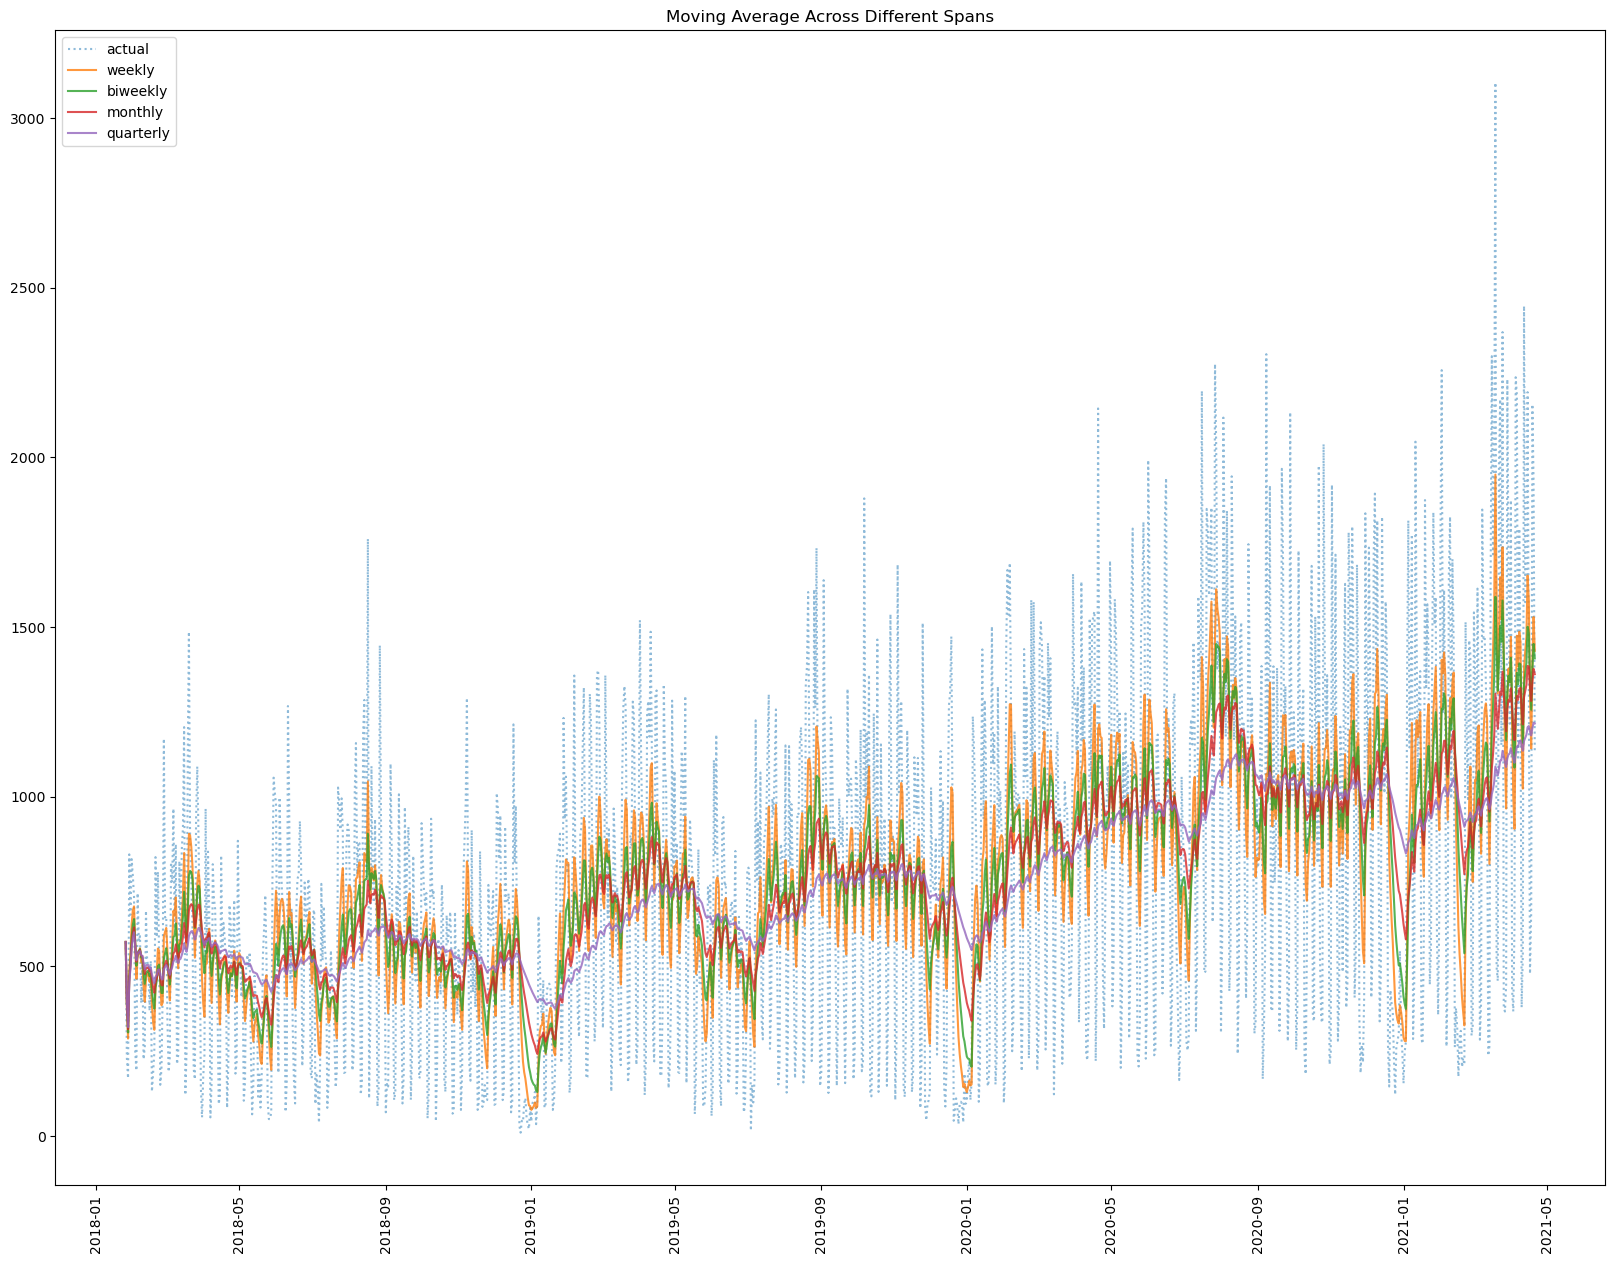

In [17]:
# lets look at a few different windows to see how these means compute
plt.figure(figsize=(20,15))
spans = [7,14,30,90]
labels = ['weekly', 'biweekly', 'monthly', 'quarterly']
plt.plot(pages, ls=':', alpha=0.5, label='actual')
for i, label in zip(spans, labels):
    plt.plot(pages.ewm(span=i).mean(),
             label=label, alpha=0.8)
plt.legend()
plt.title('Moving Average Across Different Spans')
plt.xticks(rotation=90)
plt.show()

In [18]:
# set the window span
span = 30
# set the std dev
k = 3
# compute midband
midband = pages.ewm(span=span).mean()

midband.head()


date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: path, dtype: float64

In [19]:
# three standard devs up from the mid band will be our upper band
upper_band = midband + (k * pages.ewm(span=span).std())
# three standard devs down from the mid will be our lower band
lower_band = midband - (k * pages.ewm(span=span).std())

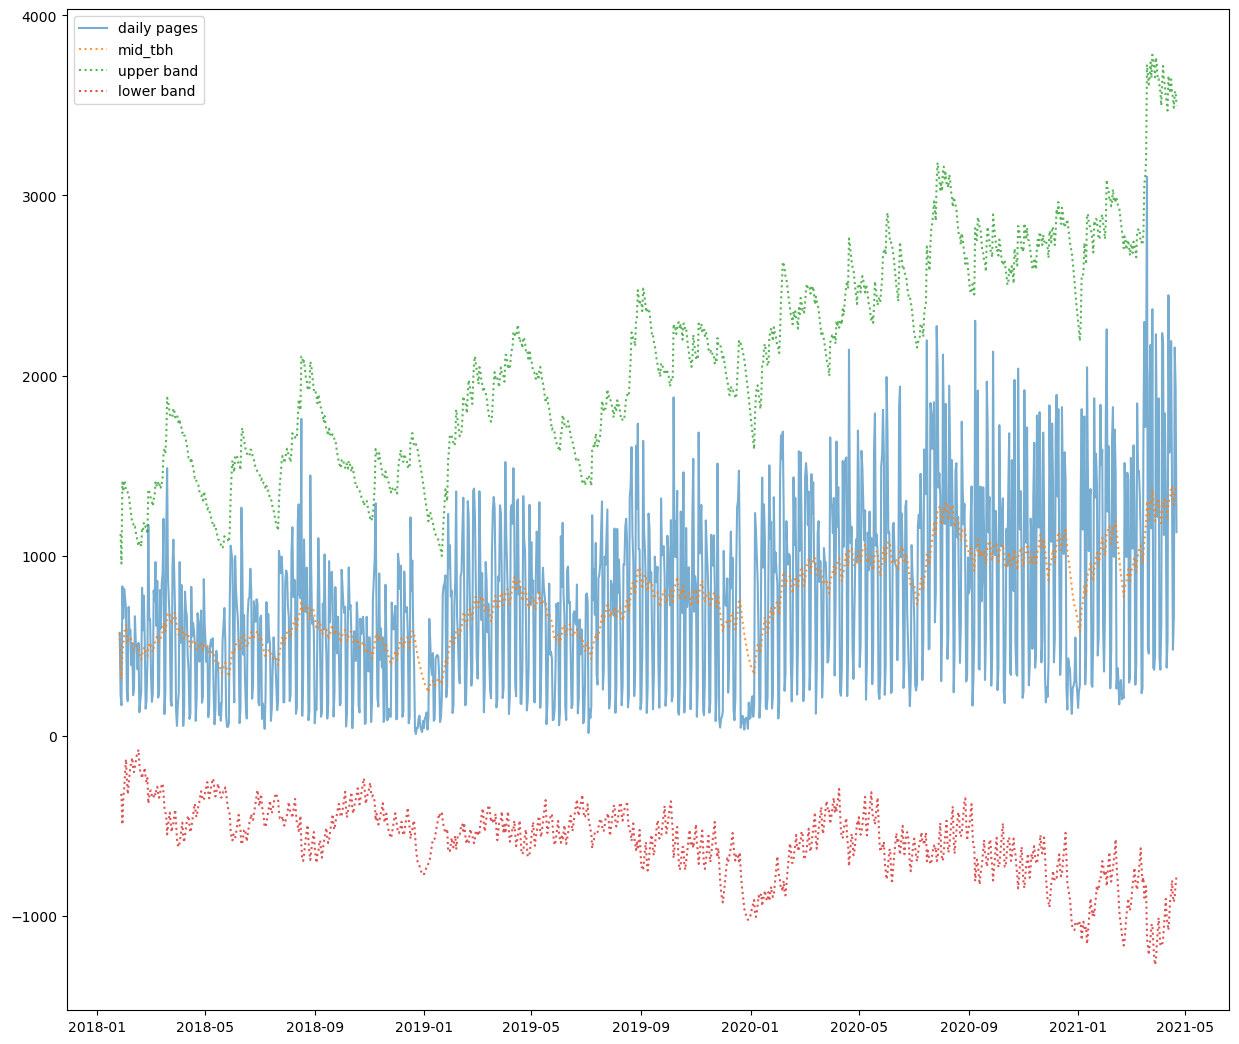

In [20]:
# lets visualize those:
plt.figure(figsize=(15,13))
plt.plot(pages, alpha=0.6, label='daily pages')
plt.plot(midband, alpha=0.8, ls=':', label='mid_tbh')
plt.plot(upper_band, alpha=0.8, ls=':', label='upper band')
plt.plot(lower_band, alpha=0.8, ls=':',label='lower band')
plt.legend()
plt.show()

In [25]:
# combine into 1 df
bb_df = pd.concat([pages, midband, upper_band, lower_band], axis=1)

In [26]:
bb_df.columns = ['observed', 'midband', 'ub', 'lb']
bb_df.head()

,observed,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116


In [28]:
# Calc pct b
bb_df['prcnt_b'] = (bb_df['observed'] - bb_df['lb']) / (bb_df['ub'] - bb_df['lb'])

In [29]:
bb_df.head()

,observed,midband,ub,lb,prcnt_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899
2018-01-29,830,457.002386,1406.405897,-492.401124,0.696438
2018-01-30,652,501.369064,1354.808245,-352.070116,0.588249


In [30]:
bb_df[bb_df.prcnt_b > 0.8].shape

(21, 5)

## Pull it all together

In [35]:

def prep(df, user):
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages = df['path'].resample('d').count()
    return pages

def compute_pct_b(pages, span, weight, user):
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

def find_anomalies(df, user, span, weight):
    pages = prep(df, user)
    my_df = compute_pct_b(pages, span, weight, user)
    # plt_bands(my_df, user)
    return my_df[my_df.pct_b>1]


In [32]:
df = pd.read_csv('logs.csv')

In [34]:
df.head()

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [36]:
prep(df, 1)

/var/folders/mj/fstq2n8s1gs942htzygkxlj40000gn/T/ipykernel_6413/3480276815.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.date = pd.to_datetime(df.date)


date
2018-01-26     7
2018-01-27     1
2018-01-28     0
2018-01-29     6
2018-01-30     5
              ..
2021-04-17     0
2021-04-18     8
2021-04-19    10
2021-04-20    11
2021-04-21    12
Freq: D, Name: path, Length: 1182, dtype: int64